# Bias and Explainability-Tabular Data

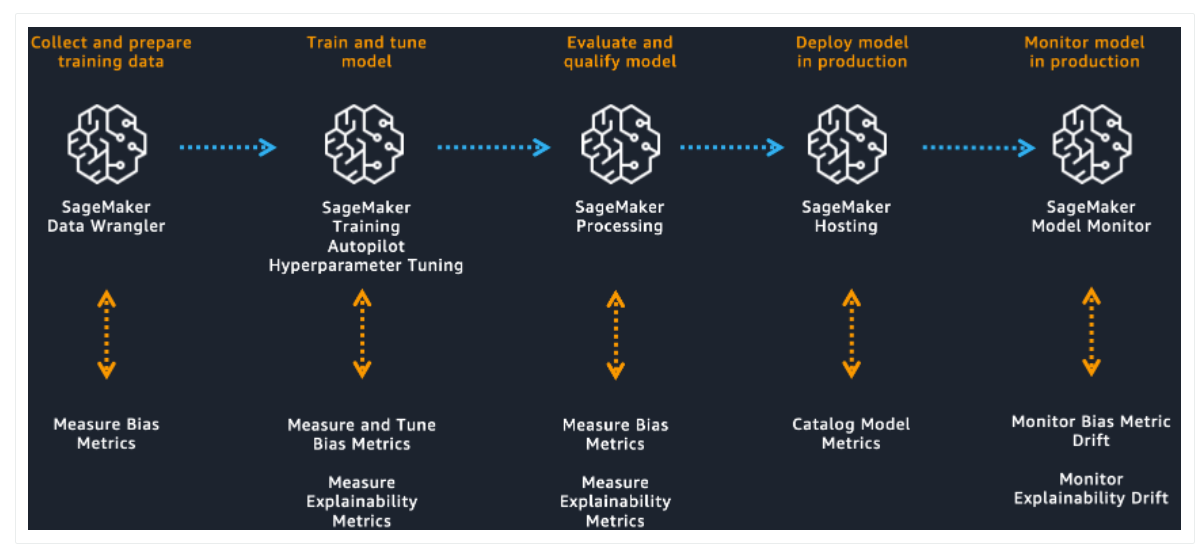

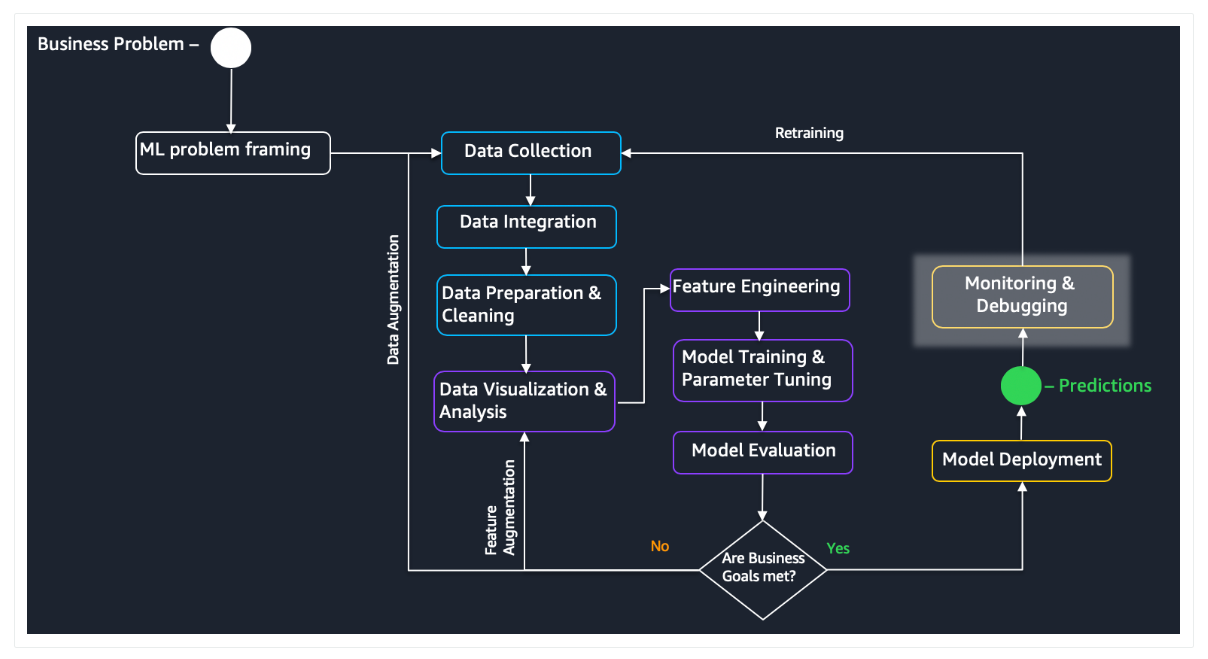

## Credit risk prediction, explainability and bias detection with Amazon SageMaker

![Credit risk explainability use case](credit_risk_prediction.png)

Amazon SageMaker Clarify는 잠재적인 bias를 감지하고 이러한 모델이 어떻게 예측하는지 설명함으로써 머신러닝 모델을 개선하는데 도움이 된다. SageMaker Clarify가 제공하는 fairness와 explainability 가능성 기능은 AWS 고객이 신뢰할 수 있고 이해할 수 있는 머신러닝 모델을 구축할 수 있도록 한다.

---

### 1. Overview
- 이번 실습에서 Credit-risk의 End to End ML use case에 대한 model explainability와 bias detection을 진행
    - 1) Measuring the pre-training bias of a dataset and post-training bias of a model
    - 2) Explaining the importance of the various input features on the model's decision
    - 3) Accessing the reports through SageMaker Studio if you have an instance set up

![Credit risk explainability model inference](clarify_inf_pipeline_arch.jpg)

1. Prepare raw training and test data - [South German Credit (UPDATE) Data Set](https://archive.ics.uci.edu/ml/datasets/South+German+Credit+%28UPDATE%29)
2. Create a SageMaker Processing job which performs preprocessing on the raw training data and also produces an SKlearn model which is reused for deployment
3. Train an XGBoost model on the processed data using SageMaker's built-in XGBoost container
4. Create a SageMaker Inference pipeline containing the SKlearn and XGBoost model in a series
5. Perform inference by supplying raw test data
6. Set up and run explainability job powered by SageMaker Clarify
7. Use open source SHAP library to create summary and waterfall plots to understand the feature importance better
8. Run bias analysis jobs
9. Clean up

### 2. Prerequisites and Data exploration and Feature engineering

Initialize SageMaker

In [1]:
from io import StringIO
import os
import time
import sys
import IPython
from time import gmtime, strftime

import boto3
import numpy as np
import pandas as pd
import urllib

import sagemaker
from sagemaker.s3 import S3Uploader
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.inputs import TrainingInput
from sagemaker.xgboost import XGBoost
from sagemaker.s3 import S3Downloader
from sagemaker.s3 import S3Uploader
from sagemaker import Session
from sagemaker import get_execution_role
from sagemaker.xgboost import XGBoostModel
from sagemaker.sklearn import SKLearnModel
from sagemaker.pipeline import PipelineModel


session = Session()
bucket = session.default_bucket()
print("bucket: ", bucket)
prefix = "sagemaker/sagemaker-clarify-credit-risk-model"
region = session.boto_region_name
print("region: ", region)

# Define IAM role
role = get_execution_role()
print("role: ", role)

bucket:  sagemaker-ap-northeast-2-988889742134
region:  ap-northeast-2
role:  arn:aws:iam::988889742134:role/service-role/AmazonSageMaker-ExecutionRole-20220315T092490


Download data

In [2]:
S3Downloader.download(
    "s3://sagemaker-sample-files/datasets/tabular/uci_statlog_german_credit_data/SouthGermanCredit.asc",
    "data",
)

In [3]:
credit_columns = [
    "status",
    "duration",
    "credit_history",
    "purpose",
    "amount",
    "savings",
    "employment_duration",
    "installment_rate",
    "personal_status_sex",
    "other_debtors",
    "present_residence",
    "property",
    "age",
    "other_installment_plans",
    "housing",
    "number_credits",
    "job",
    "people_liable",
    "telephone",
    "foreign_worker",
    "credit_risk",
]

Data inspection

In [4]:
training_data = pd.read_csv(
    "data/SouthGermanCredit.asc",
    names=credit_columns,
    header=0,
    sep=r" ",
    engine="python",
    na_values="?",
).dropna()

In [5]:
training_data.shape

(1000, 21)

In [6]:
training_data.head(10)

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1
5,1,10,4,0,2241,1,2,1,3,1,...,1,48,3,1,2,2,1,1,1,1
6,1,8,4,0,3398,1,4,1,3,1,...,1,39,3,2,2,2,2,1,1,1
7,1,6,4,0,1361,1,2,2,3,1,...,1,40,3,2,1,2,1,1,1,1
8,4,18,4,3,1098,1,1,4,2,1,...,3,65,3,2,2,1,2,1,2,1
9,2,24,2,3,3758,3,1,1,2,1,...,4,23,3,1,1,1,2,1,2,1


In [7]:
training_data["credit_risk"].value_counts()

1    700
0    300
Name: credit_risk, dtype: int64

In [8]:
training_data['credit_risk'].value_counts().sort_values()

0    300
1    700
Name: credit_risk, dtype: int64

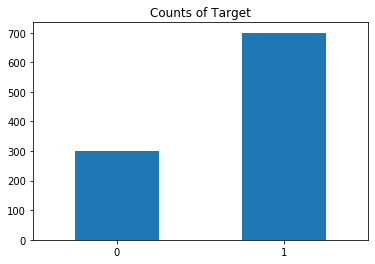

In [9]:
%matplotlib inline

training_data["credit_risk"].value_counts().sort_values().plot(
    kind="bar", title="Counts of Target", rot=0
)

Create the raw training and test CSV files

In [10]:
test_data = training_data.sample(frac=0.1)

In [11]:
test_data.shape

(100, 21)

In [12]:
test_data = test_data.drop(['credit_risk'], axis=1)

In [13]:
test_filename = "test.csv"

In [14]:
test_data.shape

(100, 20)

In [15]:
test_data.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker
510,4,6,4,0,2080,3,3,1,4,1,2,3,24,3,2,1,3,2,1,2
42,4,18,4,0,1028,1,3,4,2,1,3,1,36,3,2,2,3,2,1,2
224,1,18,2,2,2659,4,3,4,3,1,2,3,28,3,2,1,3,2,1,2
707,2,30,4,0,2181,5,5,4,3,1,4,1,36,3,2,2,3,2,1,2
417,4,24,4,1,5804,4,3,4,3,1,2,1,27,3,2,2,3,2,1,2


In [16]:
test_columns = [
    "status",
    "duration",
    "credit_history",
    "purpose",
    "amount",
    "savings",
    "employment_duration",
    "installment_rate",
    "personal_status_sex",
    "other_debtors",
    "present_residence",
    "property",
    "age",
    "other_installment_plans",
    "housing",
    "number_credits",
    "job",
    "people_liable",
    "telephone",
    "foreign_worker",
]

In [17]:
test_data.to_csv(
    test_filename,
    index=False,
    header=True,
    columns=test_columns,
    sep=","
)

In [18]:
# Prepare raw training data
train_filename = "train.csv"
training_data.to_csv(
    train_filename,
    index=False,
    header=True,
    columns=credit_columns,
    sep=","
)

Encode and Upload data

In [19]:
s3_test_raw_uri = f"s3://{bucket}/{prefix}/data/test"
print("s3 test raw uri: ", s3_test_raw_uri)

s3 test raw uri:  s3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/data/test


In [20]:
s3_train_raw_uri = f"s3://{bucket}/{prefix}/data/train"
print("s3 train raw uri: ", s3_train_raw_uri)

s3 train raw uri:  s3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/data/train


In [23]:
# upload raw test
test_raw = S3Uploader.upload(
    test_filename,
    s3_test_raw_uri
)
print(test_raw)

s3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/data/test/test.csv


In [24]:
train_raw = S3Uploader.upload(
    train_filename,
    s3_train_raw_uri
)
print(train_raw)

s3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/data/train/train.csv


Preprocessing and feature engineering with SageMaker Processing job

SageMaker Processing Job을 사용하여 raw data에 대한 preprocessing을 수행
- SageMaker Processing은 SKlearn을 위해 사전에 제작된 container를 제공

In [25]:
sklearn_processor = SKLearnProcessor(
    role=role,
    base_job_name="sagemaker-clarify-credit-risk-processing-job",
    instance_type="ml.m5.large",
    instance_count=1,
    framework_version="0.20.0"
)

In [26]:
!pygmentize processing/preprocessor.py

import argparse
import os
import warnings

import pandas as pd
import numpy as np
import tarfile
import sklearn
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer

from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action="ignore", category=DataConversionWarning)

columns = [
    "status",
    "duration",
    "credit_history",
    "purpose",
    "amount",
    "savings",
    "employment_duration",
    "installment_rate",
    "personal_status_sex",
    "other_debtors",
    "present_residence",
    "property",
    "age",
    "other_installment_plans",
    "housing",
    "number_credits",
    "job",
    "people_liable",
    "telephone",
    "foreign_worker",
    "credit_risk",
]

if __name__ == "__main__":

    # Read the arguments passed to the script.
    parser = argparse.ArgumentParser()
    parser.add_argume

In [27]:
s3_path = f"s3://{bucket}/{prefix}"
print("s3 path: ", s3_path)

s3 path:  s3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model


In [28]:
raw_data_path = s3_path + '/data/train/'
train_data_path = s3_path + '/data/preprocessed/train/'
val_data_path = s3_path + '/data/preprocessed/val/'
model_path = s3_path + '/sklearn/'
print("raw data path: ", raw_data_path)
print("train data path: ", train_data_path)
print("val data path: ", val_data_path)
print("model path: ", model_path)

raw data path:  s3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/data/train/
train data path:  s3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/data/preprocessed/train/
val data path:  s3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/data/preprocessed/val/
model path:  s3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/sklearn/


Run SKLearn Processor

In [29]:
sklearn_processor.run(
    code="processing/preprocessor.py",
    inputs=[
        ProcessingInput(
            input_name="raw_data", source=raw_data_path, destination="/opt/ml/processing/input"
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="train_data", source="/opt/ml/processing/train", destination=train_data_path
        ),
        ProcessingOutput(
            output_name="val_data", source="/opt/ml/processing/val", destination=val_data_path
        ),
        ProcessingOutput(
            output_name="model", source="/opt/ml/processing/model", destination=model_path
        ),
    ],
    arguments=["--train-test-split-ratio", "0.2"],
    logs=False,
)


Job Name:  sagemaker-clarify-credit-risk-processin-2022-05-03-03-49-47-345
Inputs:  [{'InputName': 'raw_data', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/data/train/', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-988889742134/sagemaker-clarify-credit-risk-processin-2022-05-03-03-49-47-345/input/code/preprocessor.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'train_data', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/data/preprocessed/train/', 'Loc

### 3. Train XGBoost Model

이 단계에서는 Preprocessed Data에 대한 XGBoost model을 Training 함
- SageMaker에서 제공하는 XGBoost Container가 내장된 자체 training script를 사용
- SageMaker로 자체 모델을 가져와서 SageMaker Clarify로 처리할 수 있음

In [30]:
!pygmentize training/train_xgboost.py

import argparse
import json
import os
import random
import pandas as pd
import glob
import pickle as pkl

import xgboost


def parse_args():

    parser = argparse.ArgumentParser()

    parser.add_argument("--max_depth", type=int, default=5)
    parser.add_argument("--eta", type=float, default=0.05)
    parser.add_argument("--gamma", type=int, default=4)
    parser.add_argument("--min_child_weight", type=int, default=6)
    parser.add_argument("--silent", type=int, default=0)
    parser.add_argument("--objective", type=str, default="binary:logistic")
    parser.add_argument("--eval_metric", type=str, default="auc")
    parser.add_argument("--num_round", type=int, default=100)
    parser.add_argument("--subsample", type=float, default=0.8)
    parser.add_argument("--early_stopping_rounds", type=int, default=20)

    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--validation", type=str, default=os.environ.get("SM_CHANNEL_VAL

Set up XGBoost Estimator
- Pre-defined values for Hyperparameters for XGBoost algorithm
- XGBoost Estimator for SageMaker

In [31]:
hyperparameters = {
    "max_depth": "5",
    "eta": "0.1",
    "gamma": "4",
    "min_child_weight": "6",
    "silent": "1",
    "objective": "binary:logistic",
    "num_round": "100",
    "subsample": "0.8",
    "eval_metric": "auc",
    "early_stopping_rounds": "20",
}

entry_point = "train_xgboost.py"
source_dir = "training/"
output_path = "s3://{0}/{1}/{2}".format(bucket, prefix, "xgb_model")
code_location = "s3://{0}/{1}/code".format(bucket, prefix)

estimator = XGBoost(
    entry_point=entry_point,
    source_dir=source_dir,
    output_path=output_path,
    code_location=code_location,
    hyperparameters=hyperparameters,
    instance_type="ml.c5.xlarge",
    instance_count=1,
    framework_version="0.90-2",
    py_version="py3",
    role=role,
)

SageMaker Training

In [32]:
job_name = f"credit-risk-xgb-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"

train_input = TrainingInput(
    "s3://{0}/{1}/data/preprocessed/train/".format(bucket, prefix), content_type="csv"
)
val_input = TrainingInput(
    "s3://{0}/{1}/data/preprocessed/val/".format(bucket, prefix), content_type="csv"
)

inputs = {"train": train_input, "validation": val_input}

estimator.fit(inputs, job_name=job_name)

2022-05-03 03:55:29 Starting - Starting the training job...
2022-05-03 03:55:54 Starting - Preparing the instances for trainingProfilerReport-1651550128: InProgress
......
2022-05-03 03:56:54 Downloading - Downloading input data...
2022-05-03 03:57:14 Training - Downloading the training image...
2022-05-03 03:57:59 Uploading - Uploading generated training modelINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Invoking user training script.
INFO:sagemaker-containers:Module train_xgboost does not provide a setup.py. 
Generating setup.py
INFO:sagemaker-containers:Generating setup.cfg
INFO:sagemaker-containers:Generating MANIFEST.in
INFO:sagemaker-containers:Installing module with the following command:
/miniconda3/bin/python3 -m pip install . 
Processing /opt/ml/code
  Created wheel for train-xgboost: filename=train_xgboost-1.0.0-py2.py3-none-a

### 4. Create SageMaker Model
- 엔드포인트로 배치하거나 SageMaker Clarify와 함께 사용할 수 있는 SageMaker inference pipeline model 준비

Retrieve model artifacts
- training이 끝난 Model artifact를 inference에 사용되는 docker container와 연결하는 2개의 Amazon SageMaker Model, 즉 Amazon S3에 저장된 SKlaern, XGBoost model artifact의 경로를 반환받아야 함

In [33]:
job_name

'credit-risk-xgb-2022-05-03-03-55-28'

In [34]:
preprocessor_model_data = "s3://{}/{}/{}".format(bucket, prefix, "sklearn") + "/model.tar.gz"

xgboost_model_data = (
    "s3://{}/{}/{}/{}".format(bucket, prefix, "xgb_model", job_name) + "/output/model.tar.gz"
)

print("preprocessor model data: ", preprocessor_model_data)
print("xgboost model data: ", xgboost_model_data)

preprocessor model data:  s3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/sklearn/model.tar.gz
xgboost model data:  s3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/xgb_model/credit-risk-xgb-2022-05-03-03-55-28/output/model.tar.gz


Create a SageMaker SKlearn Model Object
- 1. location of the sklearn model data
- 2. our custom inference code
- 3. SKlearn version to use

In [35]:
!pygmentize inference/sklearn/inference.py

from __future__ import print_function


from io import StringIO
import os


import pandas as pd


from sklearn.externals import joblib


feature_columns_names = [
    "status",
    "duration",
    "credit_history",
    "purpose",
    "amount",
    "savings",
    "employment_duration",
    "installment_rate",
    "personal_status_sex",
    "other_debtors",
    "present_residence",
    "property",
    "age",
    "other_installment_plans",
    "housing",
    "number_credits",
    "job",
    "people_liable",
    "telephone",
    "foreign_worker",
]


def input_fn(input_data, content_type):

    if content_type == "text/csv":
        df = pd.read_csv(StringIO(input_data), header=None, index_col=False, sep=",")

        first_row = df.iloc[0:1].values[0].tolist()

        if len(df.columns) == len(feature_columns_names):
            print("column length is correct")

            if set(first_row) == set(feature_columns_names):
                print("the row contains header, remove the row")


In [36]:
sklearn_inference_code_location = "s3://{}/{}/{}/code".format(bucket, prefix, "sklearn")

sklearn_model = SKLearnModel(
    name="sklearn-model-{0}".format(str(int(time.time()))),
    model_data=preprocessor_model_data,
    entry_point="inference.py",
    source_dir="inference/sklearn/",
    code_location=sklearn_inference_code_location,
    role=role,
    sagemaker_session=session,
    framework_version="0.20.0",
    py_version="py3",
)

Create a SageMaker XGBoost Model object

In [37]:
!pygmentize inference/xgboost/inference.py

import pickle as pkl
import json
import numpy as np
import xgboost as xgb

from sagemaker_containers.beta.framework import content_types
from sagemaker_xgboost_container import encoder as xgb_encoders


def input_fn(input_data, content_type):
    if content_type == content_types.JSON:
        print("Recieved content type is json")
        print("input_data is", input_data)
        obj = json.loads(input_data)
        print("obj", obj)
        array = np.array(obj)
        return xgb.DMatrix(array)
    else:
        print("content type is not json")
        return xgb_encoders.decode(input_data, content_type)


def model_fn(model_dir):
    model_file = model_dir + "/model.bin"
    model = pkl.load(open(model_file, "rb"))
    return model


In [38]:
xgboost_inference_code_location = "s3://{}/{}/{}/code".format(bucket, prefix, "xgb_model")

xgboost_model = XGBoostModel(
    name="xgb-model-{0}".format(str(int(time.time()))),
    model_data=xgboost_model_data,
    entry_point="inference.py",
    source_dir="inference/xgboost/",
    code_location=xgboost_inference_code_location,
    framework_version="0.90-2",
    py_version="py3",
    role=role,
    sagemaker_session=session,
)

Create a SageMaker Pipeline Model object

In [39]:
pipeline_model_name = "credit-risk-inference-pipeline-{0}".format(str(int(time.time())))

pipeline_model = PipelineModel(
    name=pipeline_model_name,
    role=role,
    models=[sklearn_model, xgboost_model],
    sagemaker_session=session,
)

In [41]:
pipeline_model.name

'credit-risk-inference-pipeline-1651550426'

Deploy Model (Optional - not needed for Clarify)

In [42]:
endpoint_name = "credit-risk-pipeline-endpoint-{0}".format(str(int(time.time())))
print(endpoint_name)

pipeline_model.deploy(
    initial_instance_count=1, instance_type="ml.m5.xlarge", endpoint_name=endpoint_name
)

credit-risk-pipeline-endpoint-1651550492
-------------!

Inference (Optional - not needed for Clarify)

In [43]:
test_dataset = S3Downloader.read_file(test_raw)

predictor = sagemaker.predictor.Predictor(
    endpoint_name,
    session,
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer(),
)

predictions = predictor.predict(test_dataset)

In [45]:
# predictions

### 5. Amazon SageMaker Clarify

Pre-requisities:

1. SageMaker Model that can be deployed to a endpoint

2. Input dataset

3. SHAP Baseline

In [46]:
from sagemaker import clarify


clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    sagemaker_session=session
)

Explaining Predictions

1. 비즈니스 요구의 확대와 모델이 왜 결정을 내렸는지에 대해 설명이 필요한 규정이 존재한다.
2. SageMaker Clarify는 SHAP 라이브러리를 사용하여 각 input feature가 최종 결정에 어떤 기여를 했는지 설명한다.
3. SageMaker Clarify는 Multi-Processing instance와 spark 기반 parallelization를 사용하는 옵션과 함께 Kernel SHAP의 scalable하고 효율적인 구현을 사용한다.
4. Kernel SHAP와 SageMaker Clarify는 모델에 구애받지 않는 기능 속성 접근 방식을 가지고 있다.
5. Explainability를 위해서 SageMaker Clarify와 함께 SageMaker 모델로 표현되는 모든 ML 모델을 사용할 수 있다.

Create a baseline for SHAP

1. 대조적인 설명 가능성 기법으로 SHAP 값은 기준 샘플에 대해서 생성된 합성 데이터에 대한 모델을 평가하여 계산된다. 동일한 경우에 대한 설명은 이 기준 샘플의 선택에 따라 다를 수 있다.

2. Bad Credit Prediction을 수행한다. 따라서, baseline choice는 E(x)가 1(good credit class)에 가깝기를 원한다.

3. mode statistics를 사용하여 baseline을 생성한다.
    - pandasDataFrame.mode()는 행 또는 열의 최빈값을 반환한다.

In [47]:
raw_train_df = pd.read_csv("train.csv", header=0, names=None, sep=",")

In [48]:
baseline = raw_train_df.drop(["credit_risk"], axis=1)

In [49]:
baseline

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker
0,1,18,4,2,1049,1,2,4,2,1,4,2,21,3,1,1,3,2,1,2
1,1,9,4,0,2799,1,3,2,3,1,2,1,36,3,1,2,3,1,1,2
2,2,12,2,9,841,2,4,2,2,1,4,1,23,3,1,1,2,2,1,2
3,1,12,4,0,2122,1,3,3,3,1,2,1,39,3,1,2,2,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,4,2,38,1,2,2,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,24,2,3,1987,1,3,2,3,1,4,1,21,3,1,1,2,1,1,2
996,1,24,2,0,2303,1,5,4,3,2,1,1,45,3,2,1,3,2,1,2
997,4,21,4,0,12680,5,5,4,3,1,4,4,30,3,3,1,4,2,2,2
998,2,12,2,3,6468,5,1,2,3,1,1,4,52,3,2,1,4,2,2,2


In [50]:
baseline = baseline.mode()

In [51]:
baseline

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker
0,4.0,24.0,2.0,3.0,1258,1.0,3.0,4.0,3.0,1.0,4.0,3.0,27.0,3.0,2.0,1.0,3.0,2.0,1.0,2.0
1,NaN,NaN,NaN,NaN,1262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,1275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,1393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,1478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
baseline = baseline.iloc[0]

In [53]:
baseline

status                        4.0
duration                     24.0
credit_history                2.0
purpose                       3.0
amount                     1258.0
savings                       1.0
employment_duration           3.0
installment_rate              4.0
personal_status_sex           3.0
other_debtors                 1.0
present_residence             4.0
property                      3.0
age                          27.0
other_installment_plans       3.0
housing                       2.0
number_credits                1.0
job                           3.0
people_liable                 2.0
telephone                     1.0
foreign_worker                2.0
Name: 0, dtype: float64

In [54]:
baseline = baseline.values

In [55]:
baseline

array([4.000e+00, 2.400e+01, 2.000e+00, 3.000e+00, 1.258e+03, 1.000e+00,
       3.000e+00, 4.000e+00, 3.000e+00, 1.000e+00, 4.000e+00, 3.000e+00,
       2.700e+01, 3.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 2.000e+00,
       1.000e+00, 2.000e+00])

In [56]:
baseline = baseline.astype("int")

In [57]:
baseline

array([   4,   24,    2,    3, 1258,    1,    3,    4,    3,    1,    4,
          3,   27,    3,    2,    1,    3,    2,    1,    2])

In [58]:
type(baseline)

numpy.ndarray

In [59]:
baseline = baseline.tolist()

In [60]:
baseline

[4, 24, 2, 3, 1258, 1, 3, 4, 3, 1, 4, 3, 27, 3, 2, 1, 3, 2, 1, 2]

Setup configurations for Clarify

1. **SHAPConfig**: to create the baseline. In this example, the mean_abs is the mean of absolute SHAP values for all instances, specified as the baseline 
2. **DataConfig**: to provide some basic information about data I/O to SageMaker Clarify. We specify where to find the input dataset, where to store the output, the header names, and the dataset type.
3. **ModelConfig**: to specify information about the trained model here we re-use the model name created earlier. 
  
  Note: To avoid additional traffic to your production models, SageMaker Clarify sets up and tears down a ephemeral endpoint while processing. ModelConfig specifies your preferred instance type and instance count used to run your model on during Clarify's processing.

In [61]:
shap_config = clarify.SHAPConfig(
    baseline=[baseline],
    num_samples=2000,  # num_samples are permutations from your features, so should be large enough as compared to number of input features, for example, 2k + 2* num_features
    agg_method="mean_abs",
    use_logit=True,
)  # we want the shap values to have log-odds units so that the equation 'shap values + expected probability =  predicted probability' for each instance record )

In [62]:
explainability_report_prefix = "{}/clarify-explainability".format(prefix)
explainability_output_path = "s3://{}/{}".format(bucket, explainability_report_prefix)

explainability_data_config = clarify.DataConfig(
    s3_data_input_path=test_raw,
    s3_output_path=explainability_output_path,
    # label='credit_risk', # target column is not present in the test dataset
    headers=test_columns,
    dataset_type="text/csv",
)

DataConfig will be deprecated on 15 Mar 2022.s3_data_distribution_type parameter will no longer be supported. Everything else will remain as is in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [63]:
model_config = clarify.ModelConfig(
    model_name=pipeline_model.name,  # specify the inference pipeline model name
    instance_type="ml.c5.xlarge",
    instance_count=1,
    accept_type="text/csv",
)

Run SageMaker Clarify Explainability job

모든 configuration을 설정했고, SageMaker Clarify Explainability job을 시작하면 일시적인 SageMaker Endpoint에 대해서 inference를 수행함과 동시에 explanations 작업을 수행

_**기존 Production Endpoint를 사용하지 않음**_

In [64]:
clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
)


Job Name:  Clarify-Explainability-2022-05-03-04-10-29-279
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/data/test/test.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/clarify-explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/clarify-explainabili

Viewing the Explainability Report

In [65]:
explainability_output_path

's3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/clarify-explainability'

In [66]:
run_explainability_job_name = clarify_processor.latest_job.job_name
run_explainability_job_name

'Clarify-Explainability-2022-05-03-04-10-29-279'

In [67]:
from IPython.core.display import display, HTML


display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(
            region, run_explainability_job_name
        )
    )
)

In [68]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}?prefix={}/">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(
            bucket, explainability_report_prefix
        )
    )
)

Download report from s3

In [69]:
!aws s3 ls $explainability_output_path/

                           PRE explanations_shap/
2022-05-03 04:24:20       1368 analysis.json
2022-05-03 04:10:30        770 analysis_config.json
2022-05-03 04:24:20     515193 report.html
2022-05-03 04:24:20     243774 report.ipynb
2022-05-03 04:24:20     183455 report.pdf


In [70]:
!aws s3 cp --recursive $explainability_output_path ./explainability_report/

download: s3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/clarify-explainability/analysis_config.json to explainability_report/analysis_config.json
download: s3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/clarify-explainability/analysis.json to explainability_report/analysis.json
download: s3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/clarify-explainability/explanations_shap/out.csv to explainability_report/explanations_shap/out.csv
download: s3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/clarify-explainability/explanations_shap/baseline.csv to explainability_report/explanations_shap/baseline.csv
download: s3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/clarify-explainability/report.html to explainability_report/report.html
download: s3://sagemaker-ap-northeast-2-988889742134/sage

View the explainability pdf report below to see global explanations with SHAP for the model.

The report also includes a SHAP summary plot for all individual instances in the dataset

In [71]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./explainability_report/report.html">Explainability Report</a></b>'))


Analyze the local explanations of indivisual predictions by Clarify

In [72]:
import json
import io


shap_values_df = pd.read_csv('explainability_report/explanations_shap/out.csv')

In [74]:
shap_values_df.shape

(100, 20)

In [75]:
shap_values_df.head(10)

,status_label0,duration_label0,credit_history_label0,purpose_label0,amount_label0,savings_label0,employment_duration_label0,installment_rate_label0,personal_status_sex_label0,other_debtors_label0,present_residence_label0,property_label0,age_label0,other_installment_plans_label0,housing_label0,number_credits_label0,job_label0,people_liable_label0,telephone_label0,foreign_worker_label0
0,1.995125e-03,1.072553,1.444580e-01,-3.158303e-01,0.515186,0.087776,-1.292308e-03,3.074829e-01,-9.905198e-02,-4.464625e-04,-5.442660e-02,1.209132e-03,-0.197853,-2.334511e-03,-5.092310e-04,-2.642236e-04,-2.260967e-03,-1.834472e-03,1.509601e-03,1.353267e-03
1,8.222305e-05,-0.128413,4.732718e-01,-3.461441e-01,0.036599,0.000931,5.009543e-05,-2.820840e-04,-3.246776e-01,-4.780218e-04,-1.690655e-01,2.889358e-01,0.199330,1.667261e-03,-9.819221e-04,-8.428579e-04,-8.511763e-04,-2.505963e-04,3.870778e-04,-1.454817e-04
2,-1.992690e+00,-0.015099,-4.061776e-03,-7.589887e-02,1.109661,0.879426,3.208807e-03,1.574073e-03,-6.936195e-04,-3.145433e-03,-1.349944e-01,-1.333200e-03,-0.031288,-6.618871e-04,-1.651618e-03,6.791653e-04,-2.951650e-04,-1.038938e-04,-1.633093e-03,3.683239e-03
3,-1.604782e+00,-0.091934,4.710670e-01,-7.059121e-01,0.687321,0.647326,4.289734e-01,-2.659312e-03,4.069632e-03,-6.510657e-03,-1.163261e-03,2.236681e-01,0.272603,-3.279869e-03,3.221685e-03,-3.694576e-03,1.220551e-03,2.164365e-03,-3.126546e-03,3.621025e-03
4,9.401601e-04,-0.001596,1.619996e-01,4.004545e-01,0.312450,0.407897,3.876879e-03,7.267564e-04,-3.614297e-03,1.255150e-03,-1.170413e-01,2.473609e-01,0.000714,4.649322e-04,-4.927010e-03,1.007469e-03,1.319671e-03,8.353042e-04,-1.442450e-03,-1.100005e-03
5,-1.552664e+00,0.357202,1.706028e-03,-1.272871e-01,0.819525,0.483276,4.543045e-01,3.604206e-01,-3.781037e-01,-2.963207e-03,-1.723826e-01,-9.239617e-02,-0.193272,-2.768462e-03,8.292470e-05,9.937967e-05,4.827396e-03,5.759372e-03,1.407665e-01,-2.165499e-03
6,4.777618e-04,0.000624,-6.368543e-04,-1.127944e-03,0.301852,0.055396,2.166239e-04,1.865465e-03,1.283299e-03,3.658580e-04,-9.236226e-04,-5.905333e-04,-0.001261,-1.340859e-03,-1.622507e-01,-5.136855e-05,-6.640418e-02,-1.746512e-04,2.479080e-01,6.203610e-04
7,3.018386e-08,-0.389850,1.215646e-08,-4.239465e-10,0.547710,0.395419,1.420410e-08,7.453411e-09,-3.832455e-01,2.009355e-08,-1.989333e-08,1.924880e-09,-0.250599,-7.709447e-11,-1.740119e-08,-3.690482e-09,1.550384e-08,-1.335351e-08,-1.025160e-08,-2.335790e-08
8,-3.274102e-08,0.471403,-4.467428e-01,8.518144e-09,0.619307,0.139514,6.210272e-01,-1.969306e-08,-1.516874e-08,-2.971317e-09,1.117756e-08,-1.400879e-09,0.147411,-3.007461e-01,1.853370e-08,4.099615e-09,-1.348976e-01,-2.088799e-01,2.040811e-08,-5.297483e-08
9,-1.752678e+00,0.002902,-1.565912e-01,3.051108e-03,0.423153,0.240155,8.708950e-01,1.333955e-01,-3.544921e-01,-7.954761e-04,-1.709362e-01,-5.073765e-02,-0.116842,-2.518675e-03,-1.255869e-01,-2.211013e-03,1.671680e-03,-3.416335e-03,2.352300e-01,-1.709466e-03


Log Odd Ratio [here](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=sw4r&logNo=221150181217)

#### A brief technical summary of prediction output before the logistic link function and SHAP values

y = f(x) is the log-odd (logit) unit for the prediction output

E(y) is the log-odd (logit) unit for the prediction on the input baseline

SHAP values are in log-odd units as well 

The following is expected to hold true for every individual prediction : 

sum(SHAP values) + E(y)) == model_prediction_logit

logistic(model_prediction_logit) = model_prediction_probability

E(y) < 0 implies baseline probability less than 0.5 (bad credit baseline)

E(y) > 0 implies baseline probability greater than 0.5 (good credit baseline)

y < 0 implies predicted probability less than 0.5 (bad credit)

y > 0 implies predicted probability greater than 0.5 (good credit) 

#### We can retrieve E(y), the log-odd unit of the prediction for the baseline input

In [81]:
from IPython.display import JSON


with open("explainability_report/analysis.json") as json_file:
    data = json.load(json_file)
    base_value = data["explanations"]["kernel_shap"]["label0"]["expected_value"]


print("E(y): ", base_value)

E(y):  1.3189524577840586


E(y) > 0 implies baseline probability greater than 0.5 (good credit baseline).

---

Create a dataframe containing the model predictions generated earlier during inference

In [82]:
predictions_df = pd.DataFrame(predictions, columns=["probability_score"])

In [84]:
predictions_df.shape

(100, 1)

In [85]:
predictions_df.head()

,probability_score
0,0.9413855
1,0.79381466
2,0.7414721
3,0.83769065
4,0.9388045


Join the predictions, SHAP value and test data

In [86]:
predictions_df.reset_index(drop=True, inplace=True)

In [87]:
predictions_df.shape

(100, 1)

In [88]:
predictions_df.head()

,probability_score
0,0.9413855
1,0.79381466
2,0.7414721
3,0.83769065
4,0.9388045


In [89]:
shap_values_df.reset_index(drop=True, inplace=True)

In [90]:
shap_values_df.shape

(100, 20)

In [91]:
shap_values_df.head()

,status_label0,duration_label0,credit_history_label0,purpose_label0,amount_label0,savings_label0,employment_duration_label0,installment_rate_label0,personal_status_sex_label0,other_debtors_label0,present_residence_label0,property_label0,age_label0,other_installment_plans_label0,housing_label0,number_credits_label0,job_label0,people_liable_label0,telephone_label0,foreign_worker_label0
0,0.001995,1.072553,0.144458,-0.315830,0.515186,0.087776,-0.001292,0.307483,-0.099052,-0.000446,-0.054427,0.001209,-0.197853,-0.002335,-0.000509,-0.000264,-0.002261,-0.001834,0.001510,0.001353
1,0.000082,-0.128413,0.473272,-0.346144,0.036599,0.000931,0.000050,-0.000282,-0.324678,-0.000478,-0.169066,0.288936,0.199330,0.001667,-0.000982,-0.000843,-0.000851,-0.000251,0.000387,-0.000145
2,-1.992690,-0.015099,-0.004062,-0.075899,1.109661,0.879426,0.003209,0.001574,-0.000694,-0.003145,-0.134994,-0.001333,-0.031288,-0.000662,-0.001652,0.000679,-0.000295,-0.000104,-0.001633,0.003683
3,-1.604782,-0.091934,0.471067,-0.705912,0.687321,0.647326,0.428973,-0.002659,0.004070,-0.006511,-0.001163,0.223668,0.272603,-0.003280,0.003222,-0.003695,0.001221,0.002164,-0.003127,0.003621
4,0.000940,-0.001596,0.162000,0.400455,0.312450,0.407897,0.003877,0.000727,-0.003614,0.001255,-0.117041,0.247361,0.000714,0.000465,-0.004927,0.001007,0.001320,0.000835,-0.001442,-0.001100


In [92]:
test_data.reset_index(drop=True, inplace=True)

In [93]:
test_data.shape

(100, 20)

In [94]:
test_data.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker
0,4,6,4,0,2080,3,3,1,4,1,2,3,24,3,2,1,3,2,1,2
1,4,18,4,0,1028,1,3,4,2,1,3,1,36,3,2,2,3,2,1,2
2,1,18,2,2,2659,4,3,4,3,1,2,3,28,3,2,1,3,2,1,2
3,2,30,4,0,2181,5,5,4,3,1,4,1,36,3,2,2,3,2,1,2
4,4,24,4,1,5804,4,3,4,3,1,2,1,27,3,2,2,3,2,1,2


In [95]:
prediction_shap_df = pd.concat(
    [predictions_df, shap_values_df, test_data],
    axis=1
)

In [96]:
prediction_shap_df.shape

(100, 41)

In [97]:
prediction_shap_df.head()

,probability_score,status_label0,duration_label0,credit_history_label0,purpose_label0,amount_label0,savings_label0,employment_duration_label0,installment_rate_label0,personal_status_sex_label0,...,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker
0,0.9413855,0.001995,1.072553,0.144458,-0.315830,0.515186,0.087776,-0.001292,0.307483,-0.099052,...,2,3,24,3,2,1,3,2,1,2
1,0.79381466,0.000082,-0.128413,0.473272,-0.346144,0.036599,0.000931,0.000050,-0.000282,-0.324678,...,3,1,36,3,2,2,3,2,1,2
2,0.7414721,-1.992690,-0.015099,-0.004062,-0.075899,1.109661,0.879426,0.003209,0.001574,-0.000694,...,2,3,28,3,2,1,3,2,1,2
3,0.83769065,-1.604782,-0.091934,0.471067,-0.705912,0.687321,0.647326,0.428973,-0.002659,0.004070,...,4,1,36,3,2,2,3,2,1,2
4,0.9388045,0.000940,-0.001596,0.162000,0.400455,0.312450,0.407897,0.003877,0.000727,-0.003614,...,2,1,27,3,2,2,3,2,1,2


In [98]:
prediction_shap_df["probability_score"] = pd.to_numeric(
    prediction_shap_df["probability_score"], downcast="float"
)

In [99]:
prediction_shap_df.head()

,probability_score,status_label0,duration_label0,credit_history_label0,purpose_label0,amount_label0,savings_label0,employment_duration_label0,installment_rate_label0,personal_status_sex_label0,...,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker
0,0.941386,0.001995,1.072553,0.144458,-0.315830,0.515186,0.087776,-0.001292,0.307483,-0.099052,...,2,3,24,3,2,1,3,2,1,2
1,0.793815,0.000082,-0.128413,0.473272,-0.346144,0.036599,0.000931,0.000050,-0.000282,-0.324678,...,3,1,36,3,2,2,3,2,1,2
2,0.741472,-1.992690,-0.015099,-0.004062,-0.075899,1.109661,0.879426,0.003209,0.001574,-0.000694,...,2,3,28,3,2,1,3,2,1,2
3,0.837691,-1.604782,-0.091934,0.471067,-0.705912,0.687321,0.647326,0.428973,-0.002659,0.004070,...,4,1,36,3,2,2,3,2,1,2
4,0.938805,0.000940,-0.001596,0.162000,0.400455,0.312450,0.407897,0.003877,0.000727,-0.003614,...,2,1,27,3,2,2,3,2,1,2


Convert the probatility score to binary prediction

Probability score > 0.5 -> 1 (good credit)

Probability score < 0.5 -> 0 (bad credit)

In [100]:
prediction_shap_df.insert(
    0,
    "Prediction",
    (prediction_shap_df["probability_score"] > 0.5).astype(int)
)

In [101]:
prediction_shap_df.shape

(100, 42)

In [104]:
prediction_shap_df.head(10)

,Prediction,probability_score,status_label0,duration_label0,credit_history_label0,purpose_label0,amount_label0,savings_label0,employment_duration_label0,installment_rate_label0,...,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker
0,1,0.941386,1.995125e-03,1.072553,1.444580e-01,-3.158303e-01,0.515186,0.087776,-1.292308e-03,3.074829e-01,...,2,3,24,3,2,1,3,2,1,2
1,1,0.793815,8.222305e-05,-0.128413,4.732718e-01,-3.461441e-01,0.036599,0.000931,5.009543e-05,-2.820840e-04,...,3,1,36,3,2,2,3,2,1,2
2,1,0.741472,-1.992690e+00,-0.015099,-4.061776e-03,-7.589887e-02,1.109661,0.879426,3.208807e-03,1.574073e-03,...,2,3,28,3,2,1,3,2,1,2
3,1,0.837691,-1.604782e+00,-0.091934,4.710670e-01,-7.059121e-01,0.687321,0.647326,4.289734e-01,-2.659312e-03,...,4,1,36,3,2,2,3,2,1,2
4,1,0.938805,9.401601e-04,-0.001596,1.619996e-01,4.004545e-01,0.312450,0.407897,3.876879e-03,7.267564e-04,...,2,1,27,3,2,2,3,2,1,2
5,1,0.805796,-1.552664e+00,0.357202,1.706028e-03,-1.272871e-01,0.819525,0.483276,4.543045e-01,3.604206e-01,...,2,2,25,3,2,1,3,2,2,2
6,1,0.844854,4.777618e-04,0.000624,-6.368543e-04,-1.127944e-03,0.301852,0.055396,2.166239e-04,1.865465e-03,...,4,3,29,3,1,1,4,2,2,2
7,1,0.775283,3.018386e-08,-0.389850,1.215646e-08,-4.239465e-10,0.547710,0.395419,1.420410e-08,7.453411e-09,...,4,3,25,3,2,1,3,2,1,2
8,1,0.902591,-3.274102e-08,0.471403,-4.467428e-01,8.518144e-09,0.619307,0.139514,6.210272e-01,-1.969306e-08,...,4,3,34,1,2,1,2,1,1,2
9,1,0.620316,-1.752678e+00,0.002902,-1.565912e-01,3.051108e-03,0.423153,0.240155,8.708950e-01,1.333955e-01,...,2,2,23,3,1,2,3,2,2,2


Filter for bad credit predictions only

In [105]:
bad_credit_outcomes_df = prediction_shap_df[prediction_shap_df.iloc[:, 0] == 0]

In [106]:
bad_credit_outcomes_df.shape

(15, 42)

In [107]:
bad_credit_outcomes_df.head()

,Prediction,probability_score,status_label0,duration_label0,credit_history_label0,purpose_label0,amount_label0,savings_label0,employment_duration_label0,installment_rate_label0,...,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker
22,0,0.236052,-2.102354,0.526033,-0.316877,-0.584266,-0.001150,0.124969,0.002777,0.263049,...,2,2,25,3,1,1,3,2,1,2
23,0,0.148666,-2.010147,-0.726035,-0.001521,-0.083765,-0.408881,0.001615,-0.002216,0.359138,...,2,3,23,3,2,1,3,2,2,2
26,0,0.364089,-1.823933,-0.055412,0.007989,-0.077112,-0.017688,-0.002003,-0.283077,0.386549,...,1,4,34,1,2,1,2,2,2,2
30,0,0.487416,-1.910653,1.357722,0.000331,-0.157600,0.061193,0.001808,-0.280387,0.000130,...,4,2,23,3,2,1,3,2,1,2
42,0,0.226716,-1.446280,0.002300,0.004504,-0.690125,0.039282,-0.000921,0.562825,-0.000099,...,3,4,38,1,3,1,3,1,1,2


---

Create SHAP plots

In [109]:
!conda install -c conda-forge shap -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - shap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    shap-0.39.0                |   py37h51133e4_0         502 KB
    slicer-0.0.7               |     pyhd8ed1ab_0          16 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         519 KB

The following NEW packages will be INSTALLED:

  shap               pkgs/main/linux-64::shap-0.39.0-py37h51133e4_0
  slicer             conda-forge/noarch::slicer-0.0.7-pyhd8ed1ab_0



slicer-0.0.7         | 16 KB     | ##################################### | 100% 
shap-0.39.0          | 502 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


SHAP explanation plot for a single bad credit
- We will select the prediction instance with the lowest probability

In [110]:
import shap
import matplotlib.pyplot as plt


min_index = prediction_shap_df["probability_score"].idxmin()

In [111]:
min_index

47

In [112]:
print("mean probability of dataset: ", prediction_shap_df[["probability_score"]].mean())

mean probability of dataset:  probability_score    0.740572
dtype: float32


In [113]:
print("individual probability: ", prediction_shap_df.iloc[min_index, 1])

individual probability:  0.11505181


In [114]:
print("sum of shap values: ", prediction_shap_df.iloc[min_index, 2:22].sum())

sum of shap values:  -3.359099010057502


In [115]:
print("base value from analysis.json: ", base_value)

base value from analysis.json:  1.3189524577840586


Example 'bad credit' prediction SHAP values.

In the chart below, f(x) is the prediction of this particular individual instance in log-odd units. If negative, it means it is a bad credit prediction. 

In the chart below, E(f(x)) is the prediction of the baseline input in log-odd units. It is positive , which means it belongs to the good credit class. 

The individual example is contrasted against the good credit baseline. So the features with negative SHAP values drive the final negative decision from the initial baseline positive value.

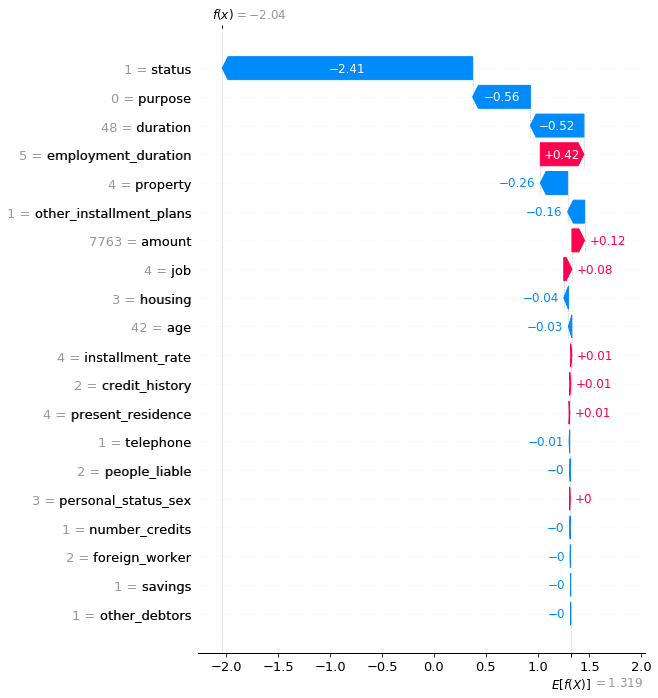

In [116]:
explanation_obj = shap._explanation.Explanation(
    values=prediction_shap_df.iloc[min_index, 2:22].to_numpy(),
    base_values=base_value,
    data=test_data.iloc[min_index].to_numpy(),
    feature_names=test_data.columns,
)
shap.plots.waterfall(shap_values=explanation_obj, max_display=20, show=False)

### Detect data bias with Amazon SageMaker Clarify

Calculate pre-training and post-training Bias metrics

DataConfig 개체는 데이터 I/O에 대한 몇 가지 기본 정보를 명확하게 전달합니다. 입력 데이터 세트를 찾을 위치, 출력을 저장할 위치, 대상 열(라벨), 헤더 이름 및 데이터 세트 유형을 지정한다.

마찬가지로 ModelConfig(설명 가능성 작업을 위해 이전에 생성된) 개체는 훈련된 모델에 대한 정보를 전달하고 ModelPredictedLabelConfig는 예측 형식에 대한 정보를 제공합니다.

In [117]:
bias_report_prefix = "{}/clarify-bias".format( prefix)
bias_report_output_path = "s3://{}/{}".format(bucket,bias_report_prefix)
bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_raw,
    s3_output_path=bias_report_output_path,
    label="credit_risk",
    headers=training_data.columns.to_list(),
    dataset_type="text/csv",
)
predictions_config = clarify.ModelPredictedLabelConfig(label=None, probability=0)

DataConfig will be deprecated on 15 Mar 2022.s3_data_distribution_type parameter will no longer be supported. Everything else will remain as is in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [118]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1],
    facet_name="age",
    facet_values_or_threshold=[40],
    group_name="personal_status_sex",
)

In [119]:
clarify_processor.run_bias(
    data_config=bias_data_config,
    bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    pre_training_methods="all",
    post_training_methods="all",
)


Job Name:  Clarify-Bias-2022-05-03-06-09-53-673
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/data/train/train.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/clarify-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/clarify-bias', 'LocalPath': '/opt/ml/p

Viewing the Bias detection Report

In [120]:
bias_report_output_path

's3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/clarify-bias'

In [121]:
run_post_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_post_training_bias_processing_job_name

'Clarify-Bias-2022-05-03-06-09-53-673'

In [122]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(
            region, run_post_training_bias_processing_job_name
        )
    )
)

In [123]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(
            region, run_post_training_bias_processing_job_name
        )
    )
)

In [124]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}?prefix={}/">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(
            bucket, bias_report_prefix
        )
    )
)

Download Clarify-bias Report from s3

In [125]:
!aws s3 ls $bias_report_output_path/

2022-05-03 06:23:01       5105 analysis.json
2022-05-03 06:09:54        861 analysis_config.json
2022-05-03 06:23:01     346201 report.html
2022-05-03 06:23:01      75580 report.ipynb
2022-05-03 06:23:01      90731 report.pdf


In [126]:
!aws s3 cp --recursive $bias_report_output_path ./generated_bias_report

download: s3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/clarify-bias/analysis.json to generated_bias_report/analysis.json
download: s3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/clarify-bias/analysis_config.json to generated_bias_report/analysis_config.json
download: s3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/clarify-bias/report.pdf to generated_bias_report/report.pdf
download: s3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/clarify-bias/report.ipynb to generated_bias_report/report.ipynb
download: s3://sagemaker-ap-northeast-2-988889742134/sagemaker/sagemaker-clarify-credit-risk-model/clarify-bias/report.html to generated_bias_report/report.html


View the bias report pdf that contains the pre-training bias and post-training bias metrics

In [127]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./generated_bias_report/report.html">Bias Report</a></b>'))

View Bias Report in Studio

In [128]:
with open ("generated_bias_report/analysis.json") as json_file:
    data = json.load(json_file)
    print("pre-training bias metrics")
    class_imbalance = data["pre_training_bias_metrics"]["facets"]["age"][0]["metrics"][1]["value"]
    print("class imbalance: ", class_imbalance)
    DPL = data["pre_training_bias_metrics"]["facets"]["age"][0]["metrics"][2]["value"]
    print("DPL: ", DPL)
    print("\n")
    print("post training bias metrics")
    DPPL = data["post_training_bias_metrics"]["facets"]["age"][0]["metrics"][6]["value"]
    print("DPPL: ", DPPL)
    DI = data["post_training_bias_metrics"]["facets"]["age"][0]["metrics"][5]["value"]
    print("DI: ", DI)

pre-training bias metrics
class imbalance:  0.456
DPL:  -0.04848093083387206


post training bias metrics
DPPL:  -0.03462346477052358
DI:  1.0436843714955653


6. Clean Up

In [129]:
session.delete_endpoint(endpoint_name)

In [130]:
session.delete_model(pipeline_model.name)

### 7. Additional Resources to explore

* [Working toward fairer machine learning](https://www.amazon.science/research-awards/success-stories/algorithmic-bias-and-fairness-in-machine-learning)
* [Fairness Measures for Machine Learning in Finance](https://pages.awscloud.com/rs/112-TZM-766/images/Fairness.Measures.for.Machine.Learning.in.Finance.pdf)
* [Amazon SageMaker Clarify: Machine learning bias detection and explainability in the cloud](https://www.amazon.science/publications/amazon-sagemaker-clarify-machine-learning-bias-detection-and-explainability-in-the-cloud)
* [Amazon AI Fairness and Explainability Whitepaper](https://pages.awscloud.com/rs/112-TZM-766/images/Amazon.AI.Fairness.and.Explainability.Whitepaper.pdf)
* [How Clarify helps machine learning developers detect unintended bias](https://www.amazon.science/latest-news/how-clarify-helps-machine-learning-developers-detect-unintended-bias)